In [3]:
!pip install --user git+https://github.com/eleurent/highway-env
# Restart kernel after installing above package to be able to import 



  Cloning https://github.com/eleurent/highway-env to c:\users\82104\appdata\local\temp\pip-req-build-y450dxhw
  Resolved https://github.com/eleurent/highway-env to commit 11452929d3eb827ac6c4d547605d5eea19039429
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/eleurent/highway-env 'C:\Users\82104\AppData\Local\Temp\pip-req-build-y450dxhw'


In [2]:
# # Install environment and visualization dependencies 
# !pip install gym pyvirtualdisplay
# !apt-get update
# !apt-get install -y xvfb python-opengl ffmpeg -y

# Environment
import gym
import highway_env

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
# torch.set_default_tensor_type("torch.cuda.FloatTensor")

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
import base64
import random

# IO
from pathlib import Path

In [3]:
# #Display functions
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

env = gym.make("parking-v0")
env.reset()

(OrderedDict([('observation',
               array([ 0.        ,  0.        , -0.        , -0.        , -0.43978264,
                      -0.89810424])),
              ('achieved_goal',
               array([ 0.        ,  0.        , -0.        , -0.        , -0.43978264,
                      -0.89810424])),
              ('desired_goal',
               array([1.400000e-01, 1.400000e-01, 0.000000e+00, 0.000000e+00,
                      6.123234e-17, 1.000000e+00]))]),
 {'speed': 0,
  'crashed': False,
  'action': array([-0.23672065, -0.20523256], dtype=float32),
  'is_success': False})

In [4]:
import torch
import numpy as np
candidate_actions = []

for steering in np.linspace(-0.5, 0.5, 11):
        for acceleration in np.linspace(0.8, 0.4, 4):
            candidate_actions.append(torch.Tensor([acceleration, steering]))
print(candidate_actions)

[tensor([ 0.8000, -0.5000]), tensor([ 0.6667, -0.5000]), tensor([ 0.5333, -0.5000]), tensor([ 0.4000, -0.5000]), tensor([ 0.8000, -0.4000]), tensor([ 0.6667, -0.4000]), tensor([ 0.5333, -0.4000]), tensor([ 0.4000, -0.4000]), tensor([ 0.8000, -0.3000]), tensor([ 0.6667, -0.3000]), tensor([ 0.5333, -0.3000]), tensor([ 0.4000, -0.3000]), tensor([ 0.8000, -0.2000]), tensor([ 0.6667, -0.2000]), tensor([ 0.5333, -0.2000]), tensor([ 0.4000, -0.2000]), tensor([ 0.8000, -0.1000]), tensor([ 0.6667, -0.1000]), tensor([ 0.5333, -0.1000]), tensor([ 0.4000, -0.1000]), tensor([0.8000, 0.0000]), tensor([0.6667, 0.0000]), tensor([0.5333, 0.0000]), tensor([0.4000, 0.0000]), tensor([0.8000, 0.1000]), tensor([0.6667, 0.1000]), tensor([0.5333, 0.1000]), tensor([0.4000, 0.1000]), tensor([0.8000, 0.2000]), tensor([0.6667, 0.2000]), tensor([0.5333, 0.2000]), tensor([0.4000, 0.2000]), tensor([0.8000, 0.3000]), tensor([0.6667, 0.3000]), tensor([0.5333, 0.3000]), tensor([0.4000, 0.3000]), tensor([0.8000, 0.4000]

In [5]:
#Defining a neural network
class DQN(nn.Module):

    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Linear(state_size, hidden_size//2)
        self.conv2 = nn.Linear(hidden_size//2, hidden_size)
        self.conv3 = nn.Linear(hidden_size, hidden_size)
        self.conv4 = nn.Linear(hidden_size, hidden_size)
        
        linear_input_size = hidden_size
        self.head = nn.Linear(linear_input_size, action_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        return self.head(x.view(x.size(0), -1))
        #x = self.head(x)
        return x

In [6]:
#Define a named tuple for transition, and replay memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
import torch.optim as optim
BATCH_SIZE = 64
#GAMMA = 0.999
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10


action_size = len(candidate_actions) #env.action_space.shape[0]  #action_size 
state_size=env.observation_space.spaces["observation"].shape[0]
hidden_size=128
n_actions = action_size


policy_net = DQN(state_size, hidden_size, action_size).cuda()
target_net = DQN(state_size, hidden_size, action_size).cuda()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(100000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END)*math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        ret_val = torch.tensor([[random.randrange(n_actions)]]).cuda()
        # print('ret_val: ',ret_val)
        return ret_val
        
episode_durations = []

In [8]:

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    dtype = torch.cuda.FloatTensor
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool).cuda()
    non_final_next_states = torch.cat([torch.from_numpy(np.array([s])) for s in batch.next_state
                                                if s is not None]).type(dtype)
    
    state_batch = torch.cat([torch.from_numpy(np.array([s])) for s in batch.state
                                                if s is not None]).type(dtype)
    action_batch = torch.cat([s for s in batch.action
                                                if s is not None]).cuda()
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE).cuda()
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    expected_state_action_values = expected_state_action_values.type(dtype)

    #Huber loss

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    loss = loss.type(dtype)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.detach()

Episode:  0 , iteration:  99 , reward:  tensor([-500.6150], device='cuda:0', dtype=torch.float64)
Episode:  1 , iteration:  99 , reward:  tensor([-500.7302], device='cuda:0', dtype=torch.float64)
Episode:  2 , iteration:  99 , reward:  tensor([-500.8503], device='cuda:0', dtype=torch.float64)
Episode:  3 , iteration:  99 , reward:  tensor([-500.3505], device='cuda:0', dtype=torch.float64)
Episode:  4 , iteration:  99 , reward:  tensor([-500.5742], device='cuda:0', dtype=torch.float64)
Episode:  5 , iteration:  99 , reward:  tensor([-500.3640], device='cuda:0', dtype=torch.float64)
Episode:  6 , iteration:  99 , reward:  tensor([-500.7720], device='cuda:0', dtype=torch.float64)
Episode:  7 , iteration:  99 , reward:  tensor([-500.4455], device='cuda:0', dtype=torch.float64)
Episode:  8 , iteration:  99 , reward:  tensor([-500.4373], device='cuda:0', dtype=torch.float64)
Episode:  9 , iteration:  99 , reward:  tensor([-500.7117], device='cuda:0', dtype=torch.float64)
Episode:  10 , itera

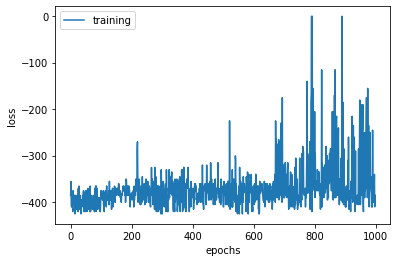

In [11]:
import math
num_episodes = 1000
dtype = torch.cuda.FloatTensor
loss_values = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    obs, done = env.reset(), False
    loss_value = 0
    for t in range(100):
        # Select and perform an action

        if len(obs) == 2 :
          action = select_action(torch.from_numpy(np.array([obs[0]["observation"]])).type(dtype))
        elif len(obs) == 3:
          action = select_action(torch.from_numpy(np.array([obs["observation"]])).type(dtype))

        obs_next, reward, done, info, _ = env.step(candidate_actions[action])
        
        reward = torch.tensor([reward]).cuda()
        if(t%99==0 and t!=0):
          print("Episode: ", i_episode, ", iteration: ", t, ", reward: ", reward)
        
        # Store the transition in memory
        if len(obs) == 2:
          memory.push(obs[0]["observation"], action, obs_next["observation"], reward)
        elif len(obs) == 3:
          memory.push(obs["observation"], action, obs_next["observation"], reward)

        # Move to the next state
        obs = obs_next
        optimize_model()
        loss = optimize_model()
        if (loss!=None):
          loss = reward.cpu()
          loss = loss.numpy()
          loss_value = loss_value + loss
    loss_values.append(loss_value/100.0)
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
# Plot losses
plt.plot(loss_values[1:])
#plt.yscale("log")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["training"])
plt.show()

In [12]:
torch.save(policy_net, 'policy_net1.pth')
# torch.load(policy_net, 'policy_net1.pth')

In [13]:
env = gym.make("parking-v0")
env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)
dtype = torch.cuda.FloatTensor
for episode in trange(20, desc="Test episodes"):
    obs, done = env.reset(), False
    while not done:
        if len(obs) == 2 :
            action = target_net(torch.from_numpy(np.array([obs[0]["observation"]])).type(dtype))
        elif len(obs) == 3 :
            action = target_net(torch.from_numpy(np.array([obs["observation"]])).type(dtype))
        action = action.cpu()
        action = action.detach()
        action = action.numpy()
        action = np.argmax(action)
        #print(action)
        action = candidate_actions[action]
        obs, reward, done, info, _ = env.step(action.numpy())

env.close()
show_video('./video')

C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\82104\OneDrive - 성균관대학교\3-2 (진짜)\1. 강화학습\제출한 과제\기말과제\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test episodes:   0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\gym\wrappers\monitoring\video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <OrderEnforcing<PassiveEnvChecker<ParkingEnv<parking-v0>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(
C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\gym\wrappers\monitoring\video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <OrderEnforcing<PassiveEnvChecker<ParkingEnv<parking-v0>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(
